### Data Loading, and Data Wrangling

In [1]:
import warnings
warnings.simplefilter('ignore')

import numpy as np
import pandas as pd
pd.set_option('display.max_columns', None)
from datetime import datetime as dt
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import auc, roc_curve, classification_report
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor  
from sklearn.ensemble import RandomForestClassifier  
from sklearn import metrics  
# Load datasets
contacts = pd.read_csv('./contacts.csv')
columns1 = contacts.columns
print(contacts.head())
#print(contacts.info())
print(contacts.describe())

listings = pd.read_csv('./listings.csv')
columns2 = listings.columns
print(listings.head())
#print(listings.info())
print(listings.describe())

users = pd.read_csv('./users.csv')
columns3 = users.columns
print(users.head())
#print(users.info())
print(users.describe())

print('contacts shape:\t',contacts.shape)
print('listings shape:\t',listings.shape)
print('users shape:\t',users.shape)

# Check uniqueness
print('Guest ID:\t', len(contacts['id_guest_anon'].unique()), '\t', len(contacts['id_guest_anon'].unique()) == len(contacts))
#print('Inquery per user:\t %2.2f' %(len(contacts)/len(contacts['id_guest_anon'].unique())))
print('Host ID:\t', len(contacts['id_host_anon'].unique()), ',\t uniqueness:\t', len(contacts['id_host_anon'].unique()) == len(contacts))
print('Host ID:\t', len(listings['id_listing_anon'].unique()), ',\t uniqueness:\t', len(listings['id_listing_anon'].unique()) == len(listings))
print('User ID:\t', len(users['id_user_anon'].unique()), ',\t uniqueness:\t', len(users['id_user_anon'].unique()) == len(users))
contacts.drop_duplicates(subset=None, keep='first', inplace=True)
users.drop_duplicates(subset=None, keep='first', inplace=True)

# Create copy of users table and relabel for guests
users_guest = users.copy()
users_guest.columns=['id_guest_anon', 'country_guest', 'words_in_guest_profile']
# Create copy of users table and relabel for hosts
users_host = users.copy()
users_host.columns=['id_host_anon', 'country_host', 'words_in_host_profile']

# Merge
merged_contacts = pd.merge(left=contacts, right=users_guest, how='left', on='id_guest_anon')
merged_contacts = pd.merge(left=merged_contacts, right=users_host, how='left', on='id_host_anon')
merged_contacts = pd.merge(left=merged_contacts, right=listings, how='left', on='id_listing_anon')
if contacts.shape[0] != merged_contacts.shape[0]:
    raise Exception ('number of rows during merge changes')
print('final table columns:\t',merged_contacts.columns)
print('final table shape:\t',merged_contacts.shape)
print(merged_contacts.info())
print(merged_contacts.describe())
print(merged_contacts.head())


                          id_guest_anon                          id_host_anon  \
0  1630694d-6e19-463c-a5b9-bc5171322487  97fa1946-b2ac-41bd-854b-0039dc911495   
1  949d0029-4349-4611-9f78-a1990d48ff4a  7bb459cb-3b97-48e9-ba87-309e9dc809c7   
2  4d94ee7f-fd1e-4528-97ac-cf25335b15e5  b15572ec-7a34-4062-8d89-e2906b1a8a31   
3  a9b23dcd-5826-4b04-8160-16ba6476afdc  35a90f9a-0e5e-448a-9a3b-103c95b470c0   
4  377d9157-cbed-444e-8d91-6be79c81d1c8  cf7199d2-7aaf-42b0-9cdb-9c63fbb2edff   

                        id_listing_anon   ts_interaction_first  \
0  e1f83a70-a590-4a2c-a138-6505f3e3de48    2016-01-17 13:33:32   
1  b8ece1d0-ed4e-4def-a845-f3cb9f9c6d80    2016-03-15 01:00:48   
2  b4f23a9f-197b-4b3e-95fd-d5d759b11b0b    2016-04-16 22:16:19   
3  f3b85ab8-9cd6-4f29-aa99-e472a82066fc  2016-01-10 20:05:02.0   
4  5ea28dcc-b2d2-4c70-972e-54948581fc8b    2016-01-26 23:15:12   

       ts_reply_at_first   ts_accepted_at_first          ts_booking_at  \
0  2016-01-17 13:36:15.0                  

## Removing outliers
### A few quick observations:
#### - There are 315 hosts with the origin country not Brazil and all the other hosts' origin countries is Brazil. It makes sense.
#### - Everything seems to make sense here except for the rows with negative total reviews which seems unrealistic . How many users are we listings about? Just 92.
#### It is just 92 listings! In this case, we can remove them, nothing will change. In general, depending on the problem, we can:
#### - remove the entire row saying you don’t trust the data
#### - treat those values as NaNs
#### - if there is a pattern, try to figure out what went wrong.
#### In doubt, we always go with removing the row. It is the safest choice. Here, I have to emphasize that wrong data is worrisome and can be an indicator of some bug in the logging code. Therefore, we would like to talk to the software engineer who implemented the code to see if, perhaps, there are some bugs which affect the data significantly.
#### Moreover, there are 4 rows with number of guests equal to zero which are removed as well.

In [2]:
# Remove outliers
# Negative guests number (will be removed)
print('\n-----------------------------------------------------------------------------------------------')
print('# Rows with negative guests number: \t {}'.format(len(merged_contacts[merged_contacts['m_guests'] < 0])))
# very long first message length (just check, not remove)
print('# Rows with long (>1000 chars) first message length (not removed): \t {}'.format(len(merged_contacts[merged_contacts['m_first_message_length_in_characters'] > 1000])))
# negative number of words in guest's profile (empty)
print("# Rows with negative # words in guest's profile: \t {}".format(len(merged_contacts[merged_contacts['words_in_guest_profile'] < 0])))
# negative number of words in host's profile (empty)
print("# Rows with negative # words in host's profile: \t {}".format(len(merged_contacts[merged_contacts['words_in_host_profile'] < 0])))
# host country not Brazil (not removed)
print('# Rows with host country not Brazil (not removed): \t {}'.format(len(merged_contacts[merged_contacts['country_host'] != 'BR'])))
# number of guests equal to zero (remove)
print('# Rows with number of guests equal to zero (removed): \t {}'.format(len(merged_contacts[merged_contacts['m_guests'] == 0])))
# negative number of total reviews for a listing (will be removed)
print('# Rows with negative total reviews (removed): \t {}'.format(len(merged_contacts[merged_contacts['total_reviews'] < 0])))
# we know these requirements for the timestamps (the ones that violate these will be removed)
# if contact_channel_first is instant_book, we should have ts_interaction_first <= ts_reply_at_first = ts_accepted_at_first =ts_booking_at
# if contact_channel_first is not instant_book, we should have ts_interaction_first <= ts_reply_at_first <= ts_accepted_at_first <= ts_booking_at
bool1 = [True] * merged_contacts.shape[0]
for i in range(merged_contacts.shape[0]):
    d0 = merged_contacts.loc[i,'contact_channel_first']
    d1 = merged_contacts.loc[i,'ts_interaction_first']
    d2 = merged_contacts.loc[i,'ts_reply_at_first']
    d3 = merged_contacts.loc[i,'ts_accepted_at_first']
    d4 = merged_contacts.loc[i,'ts_booking_at']
    d = [d1, d2, d3, d4]
    if d0 == 'instant_book':
        if str(d1) == 'NaN' or str(d2) == 'NaN' or str(d3) == 'nan' or str(d4) == 'NaN' or not(d1 <= d2 == d3 == d4):
            bool1[i] = False
    elif d0 == 'contact_me' or d0 == 'book_it':
        cleanedList = [x for x in d if str(x) != 'nan']
        if sorted(cleanedList) != cleanedList:
            bool1[i] = False
    else:
            bool1[i] = False
            print('invalid value in contact_channel_first')
print('# Rows with violated timestamp rules: \t {}'.format(len(merged_contacts[[not i for i in bool1]])))

# check check-in and checl-out dates >>>>>>>>>>>>> later

# do the removals
temp = merged_contacts.shape
merged_contacts = merged_contacts[merged_contacts['total_reviews'] >= 0]
merged_contacts = merged_contacts[merged_contacts['m_guests'] > 0]
print('>>> table rows reduced from ',temp[0],'to ',merged_contacts.shape[0])


-----------------------------------------------------------------------------------------------
# Rows with negative guests number: 	 0
# Rows with long (>1000 chars) first message length (not removed): 	 118
# Rows with negative # words in guest's profile: 	 0
# Rows with negative # words in host's profile: 	 0
# Rows with host country not Brazil (not removed): 	 315
# Rows with number of guests equal to zero (removed): 	 4
# Rows with negative total reviews (removed): 	 92
# Rows with violated timestamp rules: 	 650
>>> table rows reduced from  27887 to  27790


### Checking unique values for each column
#### showing the first 5 of the unique values for some of the columns

In [29]:
print('\n-----------------------------------------------------------------------------------------------')
print('Number of unique values in each feature:')
for column in merged_contacts.columns[0:9]:
    uniques = (merged_contacts[column].unique())
    print('{0:20s} {1:5d}\t'.format(column, len(uniques)))
for column in merged_contacts.columns[9:]:
    uniques = merged_contacts[column].unique()
    print('{0:20s} {1:5d}\t'.format(column, len(uniques)), uniques[:5])


-----------------------------------------------------------------------------------------------
Number of unique values in each feature:
id_guest_anon        22494	
id_host_anon          8938	
id_listing_anon      12780	
ts_interaction_first 27774	
ts_reply_at_first    25742	
ts_accepted_at_first 16346	
ts_booking_at        11534	
ds_checkin_first       422	
ds_checkout_first      443	
m_guests                16	 [2. 1. 4. 3. 6.]
m_interactions         110	 [5 2 3 1 7]
m_first_message_length_in_characters  1027	 [ 80.   0.  44. 220. 158.]
contact_channel_first     3	 ['contact_me' 'book_it' 'instant_book']
guest_user_stage_first     3	 ['new' 'past_booker' '-unknown-']
country_guest          122	 ['BR' 'GB' 'PT' 'US' 'AR']
words_in_guest_profile   254	 [ 0 37 22 27  1]
country_host            26	 ['BR' 'US' 'GB' 'FR' 'TH']
words_in_host_profile   332	 [68 10  0 53 64]
room_type                3	 ['Private room' 'Entire home/apt' 'Shared room']
listing_neighborhood    68	 ['Leme' '-unk

### Calculating the key metric: booking rate

In [4]:
merged_contacts['ts_booking_at'] = merged_contacts['ts_booking_at'].fillna('NaN')
print('%1.2f percent successful bookings in %2.0f inquiries' %(len(merged_contacts[merged_contacts['ts_booking_at']!='NaN'])/len(merged_contacts)*100,merged_contacts.shape[0]))

merged_contacts['booked'] = np.where(merged_contacts.ts_booking_at=='NaN', 0, 1)

41.51 percent successful bookings out of 27790 inquiries


### Visualization of different regions

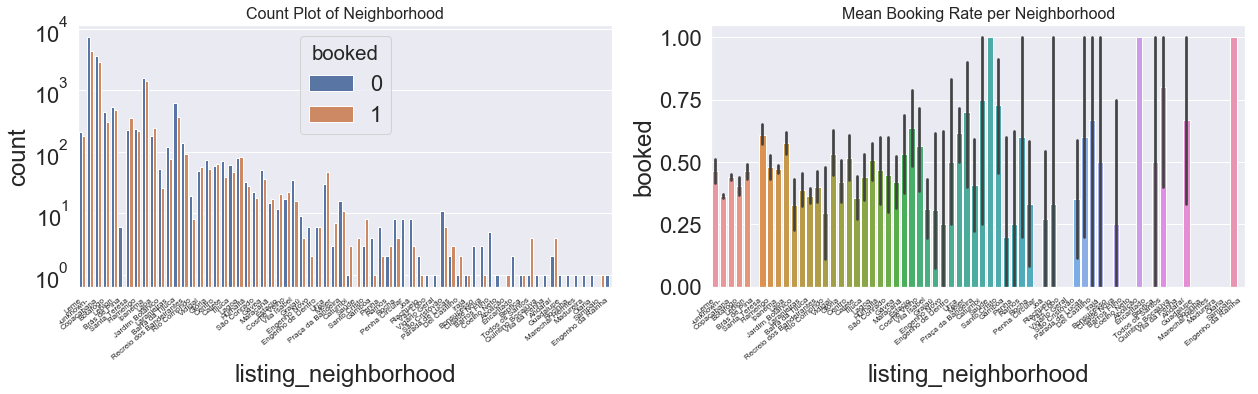

In [30]:
grouped = merged_contacts[['listing_neighborhood', 'booked']].groupby('listing_neighborhood').mean().reset_index()

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(18, 6))
sns.countplot(x='listing_neighborhood', hue='booked', data=merged_contacts, ax=ax[0])
ax[0].set_title('Count Plot of Neighborhood', fontsize=16)
ax[0].set_yscale('log')
ax[0].set_xticklabels(ax[0].get_xticklabels(), rotation=40, ha="right", fontsize=8)
sns.barplot(x='listing_neighborhood', y='booked', data=merged_contacts, ax=ax[1]);
ax[1].set_title('Mean Booking Rate per Neighborhood', fontsize=16)
ax[1].set_xticklabels(ax[1].get_xticklabels(), rotation=40, ha="right", fontsize=8)
plt.tight_layout()
plt.show()

### Visualization of guest countries
#### The long range of guest countries is representing the passion of "belonging anywhere" at Airbnb which is nice.

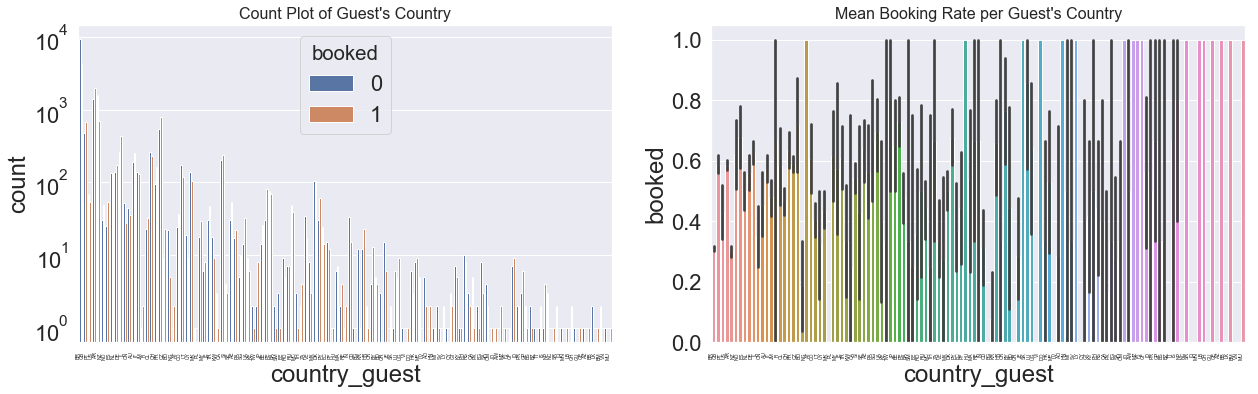

In [31]:
grouped = merged_contacts[['country_guest', 'booked']].groupby('country_guest').mean().reset_index()

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(18, 6))
sns.countplot(x='country_guest', hue='booked', data=merged_contacts, ax=ax[0])
ax[0].set_title("Count Plot of Guest's Country", fontsize=16)
ax[0].set_yscale('log')
ax[0].set_xticklabels(ax[0].get_xticklabels(), rotation=90, ha="right", fontsize=5)
sns.barplot(x='country_guest', y='booked', data=merged_contacts, ax=ax[1]);
ax[1].set_title("Mean Booking Rate per Guest's Country", fontsize=16)
ax[1].set_xticklabels(ax[1].get_xticklabels(), rotation=90, ha="right", fontsize=5)
plt.tight_layout()
plt.show()

### Visualization of different room types
#### Private rooms have the best and shared rooms have the worst booking rates. Two main reasons can be mentioned for lower booking rate of shared rooms. People interested in shared rooms are typically more price sensitive and also they care about who are their roommates. Hence, they search more to rent a shared room which results in a lower booking rate.

#### Recommendation: On one hand, if we invest on shared rooms segment, the opportunity for improvement is high but as the base value of shared rooms booking rate is relatively low, this won't make much difference. Hence, I recommend not to invest on this. On the other hand, we can invest on attracting more users to advertise private rooms like making the process easier or prioritize private rooms advertisements and recommendations in the search results page (when the guest is not filtering out private rooms). In this way, we focus on actions that we want to incentivize and users are already performing today, but it takes them several steps on the app/website to finish or there is no incentice behind it.

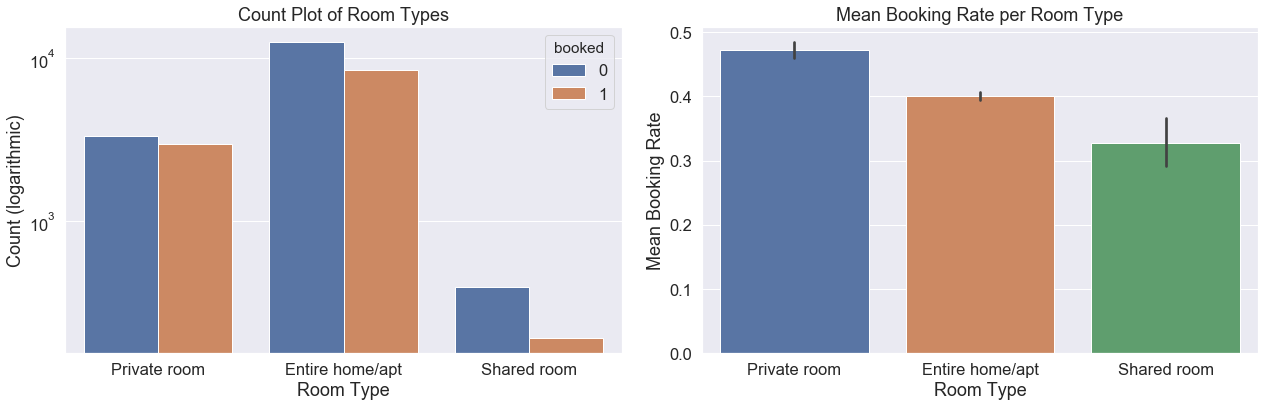

In [7]:
sns.set(font_scale=1.5)

grouped = merged_contacts[['room_type', 'booked']].groupby('room_type').mean().reset_index()

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(18, 6))
sns.countplot(x='room_type', hue='booked', data=merged_contacts, ax=ax[0])
ax[0].set_title('Count Plot of Room Types')
ax[0].set_yscale('log')
ax[0].set(xlabel='Room Type', ylabel='Count (logarithmic)')
sns.barplot(x='room_type', y='booked', data=merged_contacts, ax=ax[1]);
ax[1].set_title('Mean Booking Rate per Room Type')#, fontsize=16)
ax[1].set(xlabel='Room Type', ylabel='Mean Booking Rate')
plt.tight_layout()
plt.show()

### Visualization of different user types
#### Past bookers have better booking rate (note that the scale of the left bar plot is logarithmic). We should keep in touch with them, for example, send promotion email or coupons to past bookers. Lower booking rate of new users is normal. However, I will reach the UI development team to check whether there is something confusing on the website at the first look that makes the booking process difficult for new users. In this case, including a tutorial will help.There may be an opportunity in investigating the conversion funnel as well.

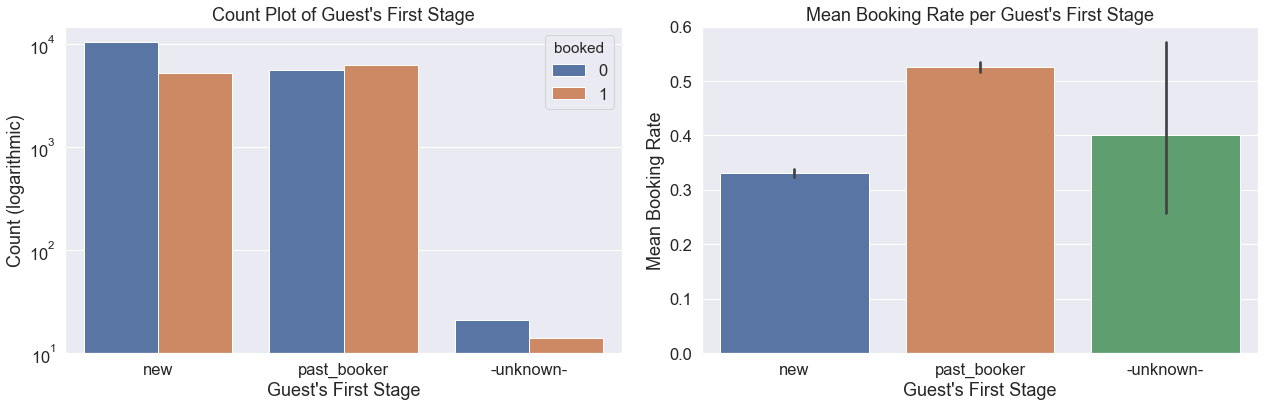

In [8]:
sns.set(font_scale=1.5)
grouped = merged_contacts[['guest_user_stage_first', 'booked']].groupby('guest_user_stage_first').mean().reset_index()

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(18, 6))
sns.countplot(x='guest_user_stage_first', hue='booked', data=merged_contacts, ax=ax[0])
ax[0].set_title("Count Plot of Guest's First Stage")
ax[0].set_yscale('log')
ax[0].set(xlabel="Guest's First Stage", ylabel='Count (logarithmic)')
sns.barplot(x='guest_user_stage_first', y='booked', data=merged_contacts, ax=ax[1]);
ax[1].set_title("Mean Booking Rate per Guest's First Stage")
ax[1].set(xlabel="Guest's First Stage", ylabel='Mean Booking Rate')
plt.tight_layout()
plt.show()

### Visualization of different number of guests
#### We first bucket the guest numbers into 3 groups, namely: #guests=1 (single traveler), #guests=2 (double like couple), #guests=3-5 (small group like family or friends), #guests>5 (large group)
#### Now, visualizing the booking rate per the traveler groups makes more sense.
#### Double travelers are the ones with the highest booking rate and large groups have the lowest booking rate by far. This somehow makes sense as hosts don't tend to rent their listing to large groups of people. On the other hand, as the number of persons in a group grows, it gets harder to reach a consensus.
#### This may be a sign of search algorithm weakness to match the users inquiring for large number of guests with the best possible listings. Divide listings based on the group that past bookers belong to. Assign a tag to listings with the history of being rented by a large group. Prioritize these listings in the search results for the guests that are aiming to travel and rent a listing in large groups.

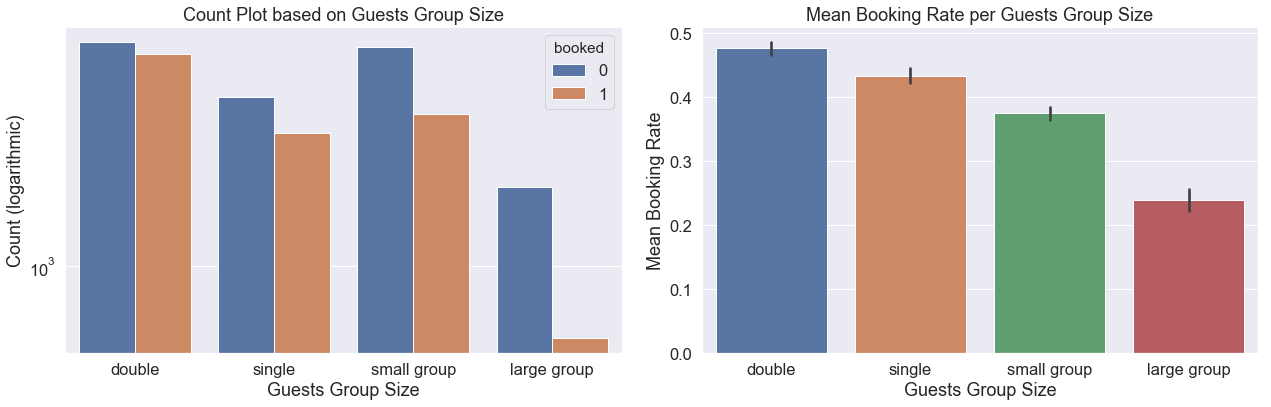

In [32]:
sns.set(font_scale=1.5)
merged_contacts['traveler_group'] = np.where(merged_contacts.m_guests==1, 'single', np.where(merged_contacts.m_guests==2, 'double', np.where(merged_contacts.m_guests<=5, 'small group', np.where(merged_contacts.m_guests>=6, 'large group','NaN'))))

grouped = merged_contacts[['traveler_group', 'booked']].groupby('traveler_group').mean().reset_index()

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(18, 6))
sns.countplot(x='traveler_group', hue='booked', data=merged_contacts, ax=ax[0])
ax[0].set_title('Count Plot based on Guests Group Size')
ax[0].set_yscale('log')
ax[0].set(xlabel="Guests Group Size", ylabel='Count (logarithmic)')
sns.barplot(x='traveler_group', y='booked', data=merged_contacts, ax=ax[1]);
ax[1].set_title('Mean Booking Rate per Guests Group Size')
ax[1].set(xlabel="Guests Group Size", ylabel='Mean Booking Rate')
plt.tight_layout()
plt.show()

### Visualization of different first contact channels
#### There are lot of users making use of "contact me" option, but their booking rate is very low. Considering how much guests are interested in this option, there is a huge opportunity if we target these users and improve their booking rate. We should consider whether our website has good contact features and satisfies users' needs and requirements.

#### Booking rate for guests using "instant book" option is 100% as anticipated. We know that there isn't a lot of guests using this feature. So, it's a huge opportunity for us to target hosts and incentivize them to opt-in to the "instant book" feature and the guests to use this. For example, put a discount on using this feature. Some other interesting ideas are discussed in the slides.

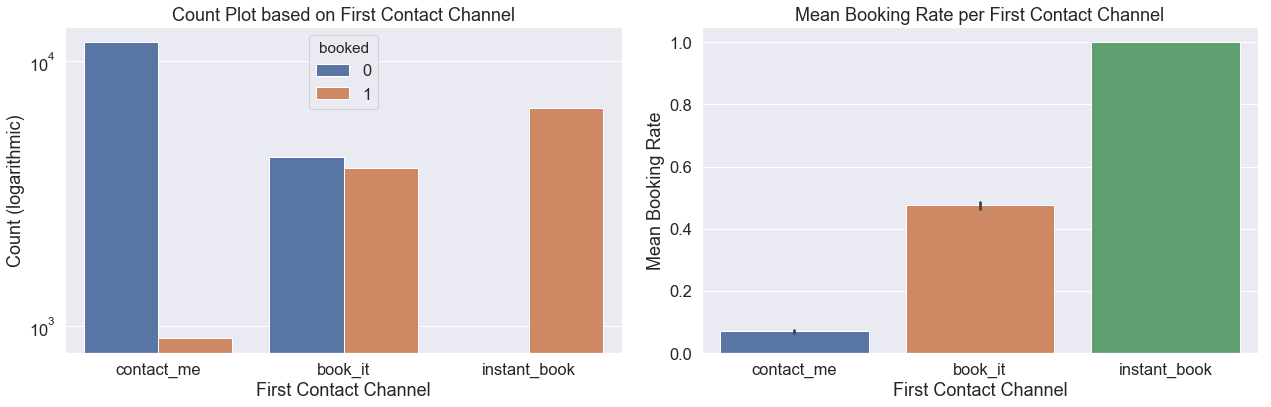

In [10]:
sns.set(font_scale=1.5)
grouped = merged_contacts[['contact_channel_first', 'booked']].groupby('contact_channel_first').mean().reset_index()

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(18, 6))
sns.countplot(x='contact_channel_first', hue='booked', data=merged_contacts, ax=ax[0])
ax[0].set_title("Count Plot based on First Contact Channel")
ax[0].set_yscale('log')
ax[0].set(xlabel="First Contact Channel", ylabel='Count (logarithmic)')
sns.barplot(x='contact_channel_first', y='booked', data=merged_contacts, ax=ax[1]);
ax[1].set_title("Mean Booking Rate per First Contact Channel")
ax[1].set(xlabel="First Contact Channel", ylabel='Mean Booking Rate')
plt.tight_layout()
plt.show()

### Visualization of different number of listing's total reviews
#### Total reviews of a listing is a positive factor. The more reviews the guest observe for a listing, the more likely he/she will book that ultimately. However, after some point (say more than 50 reviews), more total reviews does not have a tangible impact on improving the booking rate. This remindes us the fact that we would better to collect feedbacks and reviews from past bookers by sending reminder emails to them and consider rewards for giving reviews.

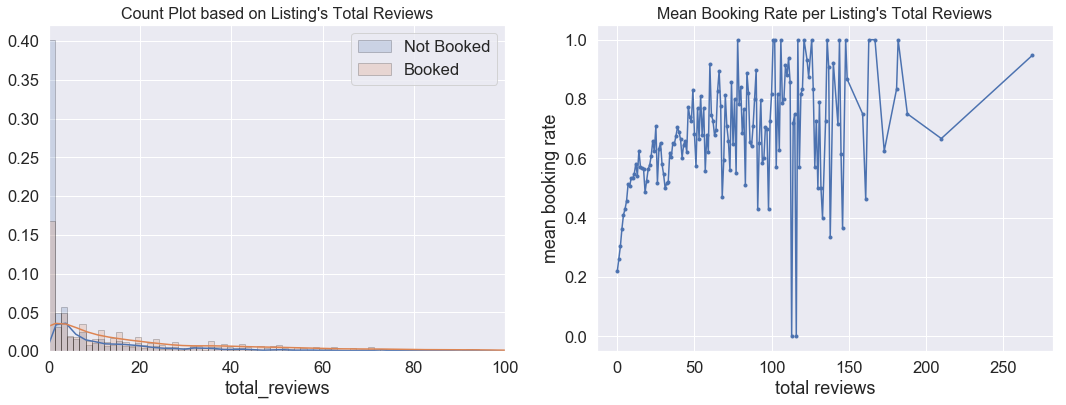

In [11]:
sns.set(font_scale=1.5)
grouped = merged_contacts[['total_reviews', 'booked']].groupby('total_reviews').mean().reset_index()
hist_kws={'histtype': 'bar', 'edgecolor':'black', 'alpha': 0.2}

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(18, 6))
sns.distplot(merged_contacts[merged_contacts['booked'] == 0]['total_reviews'], label='Not Booked', 
             ax=ax[0], hist_kws=hist_kws, bins=200)
sns.distplot(merged_contacts[merged_contacts['booked'] == 1]['total_reviews'], label='Booked', 
             ax=ax[0], hist_kws=hist_kws, bins=200)
ax[0].set_title("Count Plot based on Listing's Total Reviews", fontsize=16)
ax[0].legend()
ax[0].set_xlim(0,100)
ax[1].plot(grouped['total_reviews'], grouped['booked'], '.-')
ax[1].set_title("Mean Booking Rate per Listing's Total Reviews", fontsize=16)
ax[1].set_xlabel('total reviews')
ax[1].set_ylabel("mean booking rate")
ax[1].grid(True)
plt.show()

### Visualization of different number of words in guest's profile
####  We observe that most of the guest have zero number of words in their profile. We don't see a clear trend but it may be a good idea to ask guest to add some text in their profiles. I suggest to obtain another feature based on whether the guest has a profile photo. If so, it may give confidence to the host who wants to decide renting the listing to an identified-by-photo guest rather than a blank profile just with a name. This is another side of the challenging trust issue which is discussed in the slides.

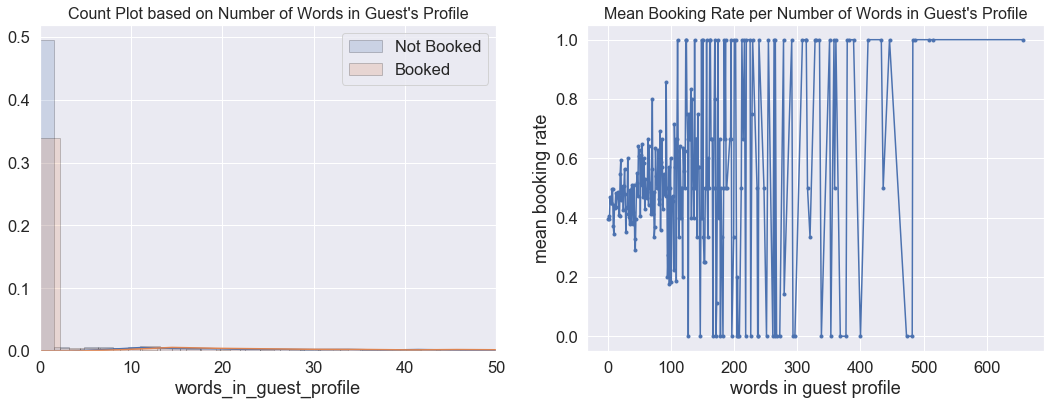

In [12]:
sns.set(font_scale=1.5)
grouped = merged_contacts[['words_in_guest_profile', 'booked']].groupby('words_in_guest_profile').mean().reset_index()
hist_kws={'histtype': 'bar', 'edgecolor':'black', 'alpha': 0.2}

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(18, 6))
sns.distplot(merged_contacts[merged_contacts['booked'] == 0]['words_in_guest_profile'], label='Not Booked', 
             ax=ax[0], hist_kws=hist_kws, bins=300)
sns.distplot(merged_contacts[merged_contacts['booked'] == 1]['words_in_guest_profile'], label='Booked', 
             ax=ax[0], hist_kws=hist_kws, bins=300)
ax[0].set_title("Count Plot based on Number of Words in Guest's Profile", fontsize=16)
ax[0].legend()
ax[0].set_xlim(0,50)
ax[1].plot(grouped['words_in_guest_profile'], grouped['booked'], '.-')
ax[1].set_title("Mean Booking Rate per Number of Words in Guest's Profile", fontsize=16)
ax[1].set_xlabel('words in guest profile')
ax[1].set_ylabel("mean booking rate")
ax[1].grid(True)
#ax[1].set_xlim(0,200)
plt.show()

### Visualization of different number of words in host's profile
#### Hosts with something in their profile description have a higher booking rate. I also suggest to obtain another feature based on whether the host has a profile photo. If so, it may give confidence to the guest who is chatting with a real person appeared in the picture, rather than deciding to pay someone with blank profile.

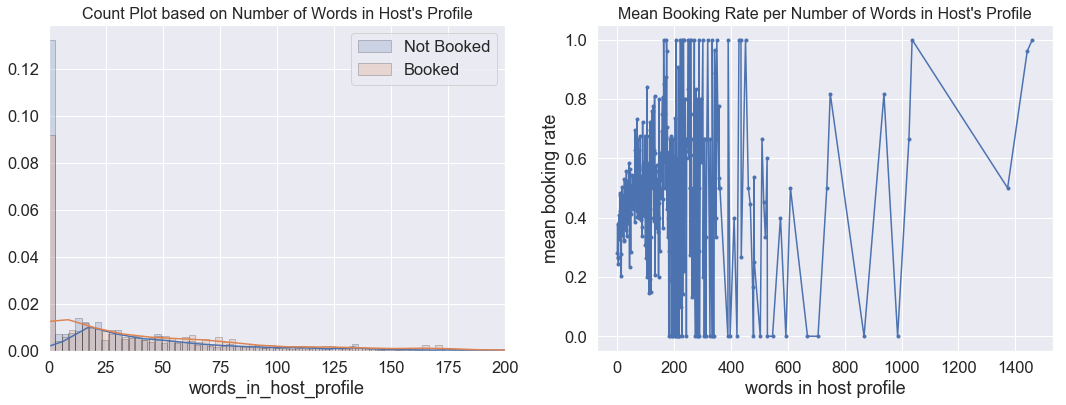

In [13]:
grouped = merged_contacts[['words_in_host_profile', 'booked']].groupby('words_in_host_profile').mean().reset_index()
hist_kws={'histtype': 'bar', 'edgecolor':'black', 'alpha': 0.2}

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(18, 6))
sns.distplot(merged_contacts[merged_contacts['booked'] == 0]['words_in_host_profile'], label='Not Booked', 
             ax=ax[0], hist_kws=hist_kws, bins=500)
sns.distplot(merged_contacts[merged_contacts['booked'] == 1]['words_in_host_profile'], label='Booked', 
             ax=ax[0], hist_kws=hist_kws, bins=500)
ax[0].set_title("Count Plot based on Number of Words in Host's Profile", fontsize=16)
ax[0].legend()
ax[0].set_xlim(0,200)
ax[1].plot(grouped['words_in_host_profile'], grouped['booked'], '.-')
ax[1].set_title("Mean Booking Rate per Number of Words in Host's Profile", fontsize=16)
ax[1].set_xlabel('words in host profile')
ax[1].set_ylabel("mean booking rate")
ax[1].grid(True)
#ax[1].set_xlim(0,200)
plt.show()

### Visualization of different number of messages
#### Definitely, spending more time on the guest-host interavtion implies higher probability of booking! This point can be elaborated by zooming in the plots in the section after this one.

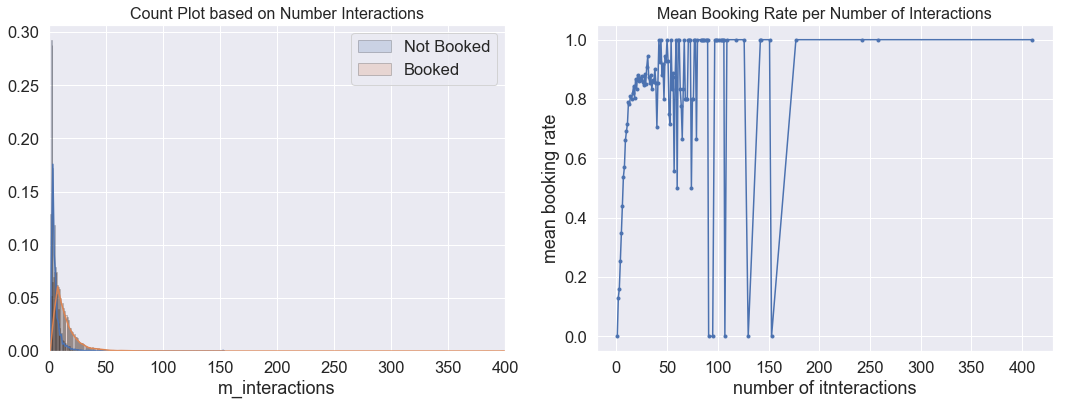

In [14]:
sns.set(font_scale=1.5)
grouped = merged_contacts[['m_interactions', 'booked']].groupby('m_interactions').mean().reset_index()
hist_kws={'histtype': 'bar', 'edgecolor':'black', 'alpha': 0.2}

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(18, 6))
sns.distplot(merged_contacts[merged_contacts['booked'] == 0]['m_interactions'], label='Not Booked', 
             ax=ax[0], hist_kws=hist_kws, bins=200)
sns.distplot(merged_contacts[merged_contacts['booked'] == 1]['m_interactions'], label='Booked', 
             ax=ax[0], hist_kws=hist_kws, bins=450)
ax[0].set_title("Count Plot based on Number Interactions", fontsize=16)
ax[0].legend()
ax[0].set_xlim(0,400)
ax[1].plot(grouped['m_interactions'], grouped['booked'], '.-')
ax[1].set_title("Mean Booking Rate per Number of Interactions", fontsize=16)
ax[1].set_xlabel('number of itnteractions')
ax[1].set_ylabel("mean booking rate")
ax[1].grid(True)
#ax[1].set_xlim(0,200)
plt.show()

### Visualization of different number of messages (zoomed plots)
#### Observe the sharp rise in the mean booking rate plot when number of interations goes up from 1 to 20. People that are more involved and spend more time on an e-commerce need, will more likely buy that. I would suggest the development team to fasciliate guest-host interaction through the website. After considering pros (like increasing guest-host interaction) and cons (like impermissible communications), maybe launching an in-app guest-host messenger will be a good idea. This needs to be verified by an A/B test. Moreover, the cost estimation of the change shouldn't only be short term, but should also include long term considerations like human labor costs, risk of bugs by adding complexity to the base code, etc.

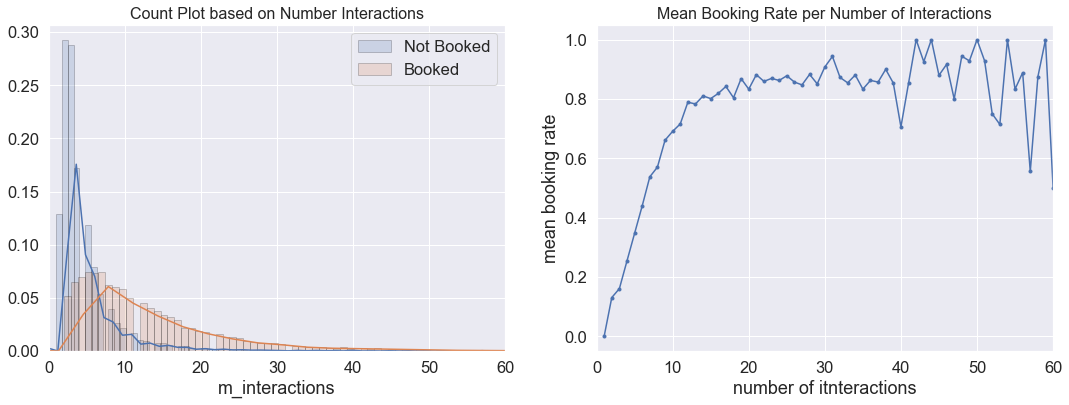

In [15]:
sns.set(font_scale=1.5)
grouped = merged_contacts[['m_interactions', 'booked']].groupby('m_interactions').mean().reset_index()
hist_kws={'histtype': 'bar', 'edgecolor':'black', 'alpha': 0.2}

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(18, 6))
sns.distplot(merged_contacts[merged_contacts['booked'] == 0]['m_interactions'], label='Not Booked', 
             ax=ax[0], hist_kws=hist_kws, bins=200)
sns.distplot(merged_contacts[merged_contacts['booked'] == 1]['m_interactions'], label='Booked', 
             ax=ax[0], hist_kws=hist_kws, bins=450)
ax[0].set_title("Count Plot based on Number Interactions", fontsize=16)
ax[0].legend()
ax[0].set_xlim(0,60)
ax[1].plot(grouped['m_interactions'], grouped['booked'], '.-')
ax[1].set_title("Mean Booking Rate per Number of Interactions", fontsize=16)
ax[1].set_xlabel('number of itnteractions')
ax[1].set_ylabel("mean booking rate")
ax[1].grid(True)
ax[1].set_xlim(0,60)
plt.show()

### Visualization of different number of characters in first guest's message
#### It is observed that the booking rate for number of characters in first guest's message equal to zero is relatively high. This is becasue the fact that message length zero corresponds to the book it and instant book option. So, we have to zoom in the region with possitive message length to see its real effect.

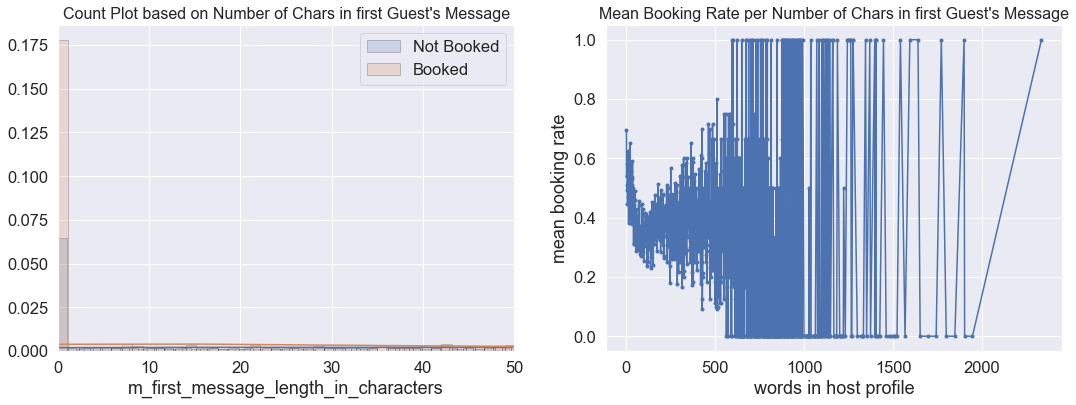

In [33]:
grouped = merged_contacts[['m_first_message_length_in_characters', 'booked']].groupby('m_first_message_length_in_characters').mean().reset_index()
hist_kws={'histtype': 'bar', 'edgecolor':'black', 'alpha': 0.2}

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(18, 6))
sns.distplot(merged_contacts[merged_contacts['booked'] == 0]['m_first_message_length_in_characters'], label='Not Booked', 
             ax=ax[0], hist_kws=hist_kws, bins=2000)
sns.distplot(merged_contacts[merged_contacts['booked'] == 1]['m_first_message_length_in_characters'], label='Booked', 
             ax=ax[0], hist_kws=hist_kws, bins=2000)
ax[0].set_title("Count Plot based on Number of Chars in first Guest's Message", fontsize=16)
ax[0].legend()
ax[0].set_xlim(0,50)
ax[1].plot(grouped['m_first_message_length_in_characters'], grouped['booked'], '.-')
ax[1].set_title("Mean Booking Rate per Number of Chars in first Guest's Message", fontsize=16)
ax[1].set_xlabel('words in host profile')
ax[1].set_ylabel("mean booking rate")
ax[1].grid(True)
#ax[1].set_xlim(0,200)
plt.show()

### Visualization of different number of characters in first guest's message (zoomed plots)
#### By zooming in the region with positive number of characters in first guest's message, we notice that if number of characters in first guest's message exceeds 40-50, it has a negative impact on the booking rate. Then, we should figure out why connections through short first messages is more successful and strengthen it. Also, we should find out why hosts don't like long first messages from the guests, and try to correct it. Is it due to the lack of interest in hosts when confronting long messages at the very first?
#### How about making a hypothesis that putting a limit on the number of characters in first guest's message will make a positive impact on the booking rate? Guests can be randomly splitted into test and control sets where test users see the limitation and control users use the old framework. Then, we analyze the results by an A/B test.

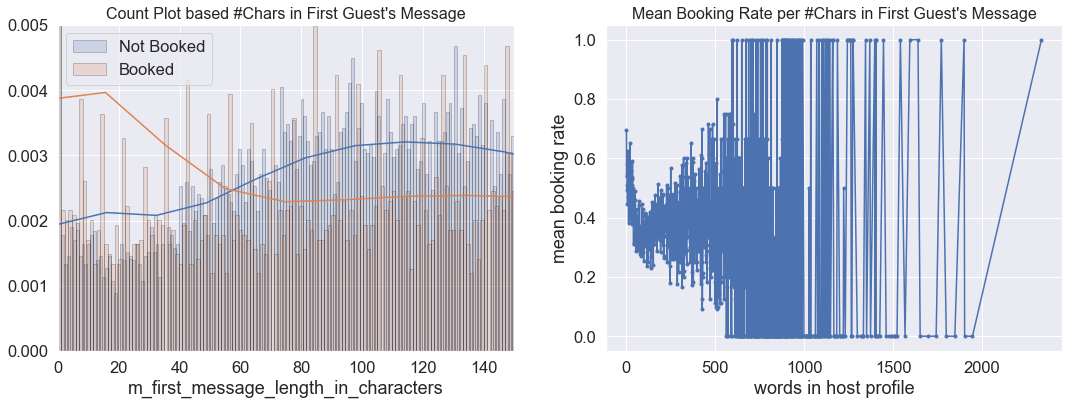

In [17]:
sns.set(font_scale=1.5)
grouped = merged_contacts[['m_first_message_length_in_characters', 'booked']].groupby('m_first_message_length_in_characters').mean().reset_index()
hist_kws={'histtype': 'bar', 'edgecolor':'black', 'alpha': 0.2}

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(18, 6))
sns.distplot(merged_contacts[merged_contacts['booked'] == 0]['m_first_message_length_in_characters'], label='Not Booked', 
             ax=ax[0], hist_kws=hist_kws, bins=2000)
sns.distplot(merged_contacts[merged_contacts['booked'] == 1]['m_first_message_length_in_characters'], label='Booked', 
             ax=ax[0], hist_kws=hist_kws, bins=2000)
ax[0].set_title("Count Plot based #Chars in First Guest's Message", fontsize=16)
ax[0].legend()
ax[0].set_xlim(0,150)
ax[0].set_ylim(0,0.005)
ax[1].plot(grouped['m_first_message_length_in_characters'], grouped['booked'], '.-')
ax[1].set_title("Mean Booking Rate per #Chars in First Guest's Message", fontsize=16)
ax[1].set_xlabel('words in host profile')
ax[1].set_ylabel("mean booking rate")
ax[1].grid(True)
#ax[1].set_xlim(0,200)
plt.show()

### Correlation heatmap plot

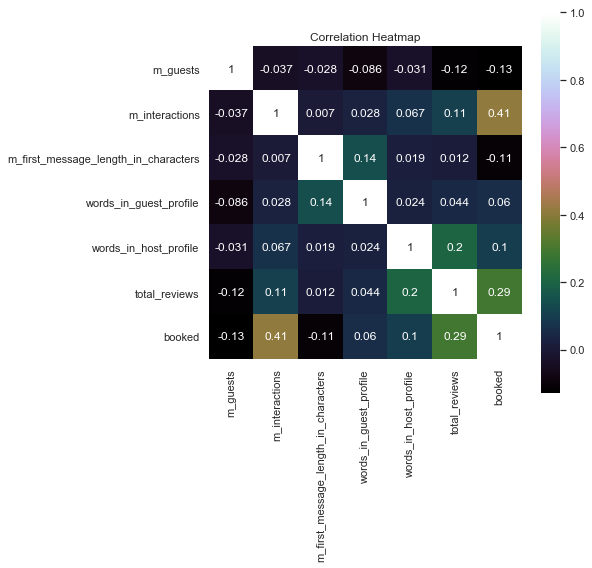

In [18]:
sns.set(font_scale=1)
ax = plt.figure(figsize=(7, 7)) 
correlation = merged_contacts.corr()
sns.heatmap(correlation, vmax=1, square=True, annot=True, cmap='cubehelix')
plt.title("Correlation Heatmap")
plt.show()

## ML classification
### One-Hot-Encoding and splitting
####  We do one-hot encoding for the categorical variables. If the data were too small, I would cross-validate.

In [23]:
x = merged_contacts.loc[:,('m_guests', 'm_interactions', 'm_first_message_length_in_characters',
                     'contact_channel_first', 'guest_user_stage_first', 'country_guest',
                     'words_in_guest_profile', 'country_host', 'words_in_host_profile',
                     'room_type', 'listing_neighborhood', 'total_reviews', 'traveler_group')]
x = pd.get_dummies(x)

# Split into 60% training and 40% test dataset
y = merged_contacts['booked']
x_train, x_test, y_train, y_test = train_test_split(x, y, stratify=y, test_size=0.4)

feature = x.columns
target = 'booked'

### Picking the machine learning model
#### I pick Logistic Regression as it usually requires very little time to optimize and it gives strong results for this problem. Moreover, we can get the feature importance coefficients from this model that specify the features with the most negitive or positive impacts. With more time, I would spend ~1 day trying other models and different parameters to pick the best.
#### Training error and test error are pretty similar: 2.83% and 2.91%. We are confident we are not overfitting. The error is pretty low noting that around 41.5% of the data is labeled 1. Note that we excluded the timestamps and dates from the features when building the model. If, for example, check in and check out dates are included, the accuracy will go a bit higher. However, our goal is not increasing the accuracy.

In [34]:
from sklearn.linear_model import LogisticRegressionCV

lrcv = LogisticRegressionCV(Cs = np.logspace(-3,3,7), dual=False, scoring='roc_auc', max_iter=1000, n_jobs=-1, verbose=1)
lrcv.fit(x_train,y_train)
lrcv.C_
lrcv.scores_
print('Training error =', 100*(1-lrcv.score(x_train,y_train)), '%')
print('Testing error', 100*(1-lrcv.score(x_test,y_test)), '%')
y_test_predict = lrcv.predict(x_test)
print(classification_report(y_true=y_test,y_pred=y_test_predict))

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   45.7s finished


Training error = 2.764940800562421 %
Testing error 3.079141598523849 %
              precision    recall  f1-score   support

           0       0.89      0.96      0.92      6502
           1       0.93      0.84      0.88      4614

   micro avg       0.91      0.91      0.91     11116
   macro avg       0.91      0.90      0.90     11116
weighted avg       0.91      0.91      0.91     11116



C:\Users\keiva\Anaconda3-2\lib\site-packages\sklearn\linear_model\logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
C:\Users\keiva\Anaconda3-2\lib\site-packages\sklearn\linear_model\logistic.py:1926: ChangedBehaviorWarning: The long-standing behavior to use the accuracy score has changed. The scoring parameter is now used. This warning will disappear in version 0.22.
  ChangedBehaviorWarning)
C:\Users\keiva\Anaconda3-2\lib\site-packages\sklearn\linear_model\logistic.py:1926: ChangedBehaviorWarning: The long-standing behavior to use the accuracy score has changed. The scoring parameter is now used. This warning will disappear in version 0.22.
  ChangedBehaviorWarning)


 ### Feature Importance Score
#### We compute and plot the most important positive and negative features for the model.

In [35]:
feat_importances = pd.DataFrame({"name":x_train.columns,"coef":lrcv.coef_[0]})
feat_importances = feat_importances[['name','coef']]# reorder the columns
feat_importances['importances'] = np.abs( feat_importances['coef'] )
feat_importances.sort_values(by="importances",inplace=True,ascending=False)
feat_importances

,name,coef,importances
8,contact_channel_first_instant_book,5.652001,5.652001
7,contact_channel_first_contact_me,-4.139913,4.139913
144,country_host_GB,-1.272114,1.272114
6,contact_channel_first_book_it,-1.254386,1.254386
153,country_host_PT,1.177123,1.177123
106,country_guest_PT,-1.087827,1.087827
40,country_guest_DK,0.860213,0.860213
22,country_guest_BE,0.781913,0.781913
115,country_guest_SG,0.750354,0.750354
226,listing_neighborhood_Vidigal,-0.739631,0.739631


#### By inspection, instant "book feature" is the most important positive variable; while, "contact me" and "book it" options have the highest negative impact on the booking rate. This was anticipated from the previous results. One important observation is the high negative impact of India and Ipanema as the guest country and listing neighborhood respectively. I would recommend the cyber security team to inspect the activity log of users from India to see if there is any spam or malware behavior. As Ipanema is a popular beach neighborhood in Rio, its high negative impact on the booking rate does not make sense. We have to investigate the listings in this neighborhood to fix any issue like unreasonable pricing.

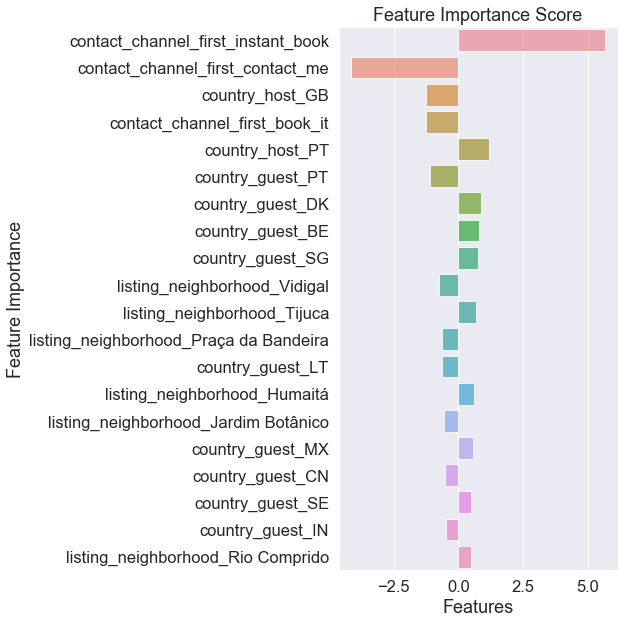

In [46]:
sns.set(font_scale=1.5)
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(5, 10))
sns.barplot(feat_importances[0:20].coef, feat_importances[0:20].name, alpha=0.8)
plt.title('Feature Importance Score')
plt.ylabel('Feature Importance')
plt.xlabel('Features')
#ax.set_xticklabels(ax.get_xticklabels(),rotation=90)
plt.show()

### Creating trip duration (in days) column

In [47]:
# Converting the date information in string to datetime type
merged_contacts['ds_checkin_first'] = pd.to_datetime(merged_contacts.ds_checkin_first)
merged_contacts['ds_checkout_first'] = pd.to_datetime(merged_contacts.ds_checkout_first)
merged_contacts['trip_duration'] = (merged_contacts['ds_checkout_first'] - merged_contacts['ds_checkin_first']).dt.days
merged_contacts.dtypes
# checking for outliers (there is nothing fortunately)
merged_contacts[merged_contacts['trip_duration']<0]
print(print(merged_contacts.loc[0:10,['trip_duration']]))

    trip_duration
0               4
1               1
2               2
3               3
4               7
5               5
6               6
7               4
8              11
9              10
10              3
None


### Visualization of trip durations
#### We first bucket the trip durations into 3 groups, namely: short trips: <=2 days, medium trips: 3-7 days, long trips: >7 days
#### Now, visualizing the booking rate per trip duration makes more sense.
#### Plotting the booking rate versus trip duration groups will tell us that the best conversion rate is for short trips and the worst is for long trips. This is expected as people travelling for a long time usually select the residence place more carefully.

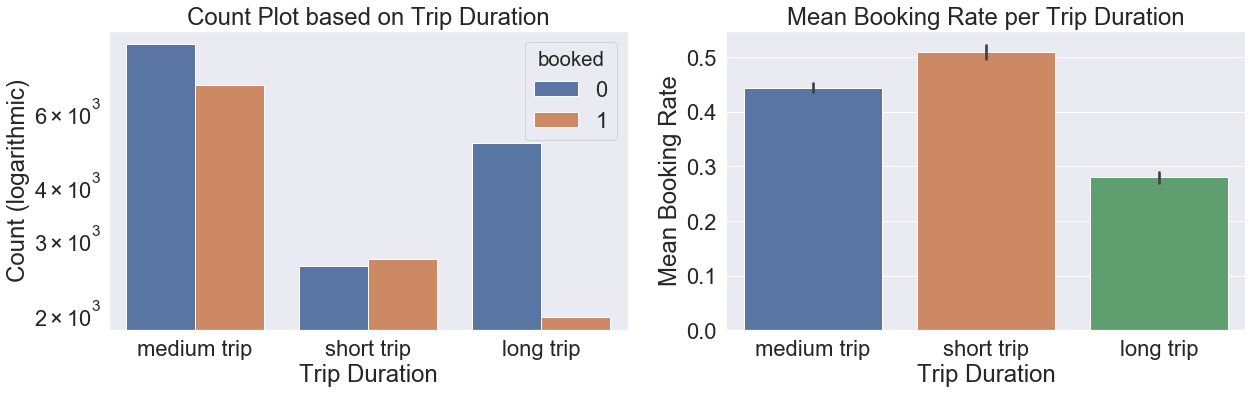

In [48]:
sns.set(font_scale=2)
merged_contacts['trip_duration_group'] = np.where(merged_contacts.trip_duration<=2, 'short trip', np.where(merged_contacts.trip_duration<=7,\
                                           'medium trip', np.where(merged_contacts.trip_duration>=8, 'long trip', None)))

grouped = merged_contacts[['trip_duration_group', 'booked']].groupby('trip_duration_group').mean().reset_index()

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(18, 6))
sns.countplot(x='trip_duration_group', hue='booked', data=merged_contacts, ax=ax[0])
ax[0].set_title('Count Plot based on Trip Duration')
ax[0].set_yscale('log')
ax[0].set(xlabel="Trip Duration", ylabel='Count (logarithmic)')
sns.barplot(x='trip_duration_group', y='booked', data=merged_contacts, ax=ax[1]);
ax[1].set_title('Mean Booking Rate per Trip Duration')
ax[1].set(xlabel="Trip Duration", ylabel='Mean Booking Rate')
plt.tight_layout()
plt.show()